# SimpleRNN을 이용한 SMS Spam 분류
<pre>
캐글 데이터: https://www.kaggle.com/uciml/sms-spam-collection-dataset
"https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv" 
</pre>

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'
df = pd.read_csv(url, encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [2]:
df.shape

(5572, 5)

### 데이터 전처리

In [3]:
# 결측열 제거
df = df[['v1', 'v2']]       # Selection
# df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
# df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
# 결측치 확인
df.isna().sum()

v1    0
v2    0
dtype: int64

In [5]:
# 중복 데이터 확인후 제거
df.v2.nunique()

5169

In [6]:
df.drop_duplicates(subset=['v2'], inplace=True)
df.shape

(5169, 2)

In [7]:
# Label Encoding: ['ham', 'spam'] --> [0, 1]
df.v1 = df.v1.replace(['ham','spam'], [0,1])
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [8]:
# Ham/Spam 갯수
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [9]:
# x, y data 분리
x = df.v2.values
y = df.v1.values
x.shape, y.shape

((5169,), (5169,))

### 텍스트 전처리

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# 구둣점 제거, 소문자 변환
import re

def preprocessing(s):
    s = s.encode('utf8').decode('ascii','ignore')   # latin1 --> ascii
    s = re.sub('[^a-z 0-9]', '', s.lower())
    return s

In [17]:
print(x[2])
X_data = [preprocessing(s) for s in x]
print(X_data[2])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s


In [18]:
# 단어 집합을 만들고, 그 크기를 확인
t = Tokenizer()         # t = Tokenizer(num_words=8000)
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9479

In [20]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [21]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [23]:
# 전체 데이터셋을 max_len 길이에 맞추고, 0 padding을 해줌
pad_X_data = pad_sequences(sequences, maxlen=max_len)

In [24]:
pad_X_data[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         54,  508,    8,   22,    4,  959,  960,   

- Train/test dataset 분리

In [25]:
import numpy as np
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    pad_X_data, y, stratify=y, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

### 모델 정의/설정/학습

In [27]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32, activation='tanh'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])

In [30]:
model_path = 'best_model.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [31]:
hist = model.fit(X_train, y_train,
                 epochs=100, batch_size=64, validation_split=0.2,
                 callbacks=[mc, es])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8543
Epoch 1: val_loss improved from inf to 0.34605, saving model to best_model.h5
52/52 [==============================] - 4s 51ms/step - loss: 0.4110 - accuracy: 0.8543 - val_loss: 0.3461 - val_accuracy: 0.8827
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8759
Epoch 2: val_loss improved from 0.34605 to 0.21901, saving model to best_model.h5
52/52 [==============================] - 2s 46ms/step - loss: 0.3124 - accuracy: 0.8767 - val_loss: 0.2190 - val_accuracy: 0.9323
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9797
Epoch 3: val_loss improved from 0.21901 to 0.11236, saving model to best_model.h5
52/52 [==============================] - 2s 46ms/step - loss: 0.1214 - accuracy: 0.9797 - val_loss: 0.1124 - val_accuracy: 0.9686
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.0532 - accur

In [32]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 11ms/step - loss: 0.0692 - accuracy: 0.9797


[0.06916914880275726, 0.9796905517578125]

- 시각화

In [33]:
import matplotlib.pyplot as plt
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

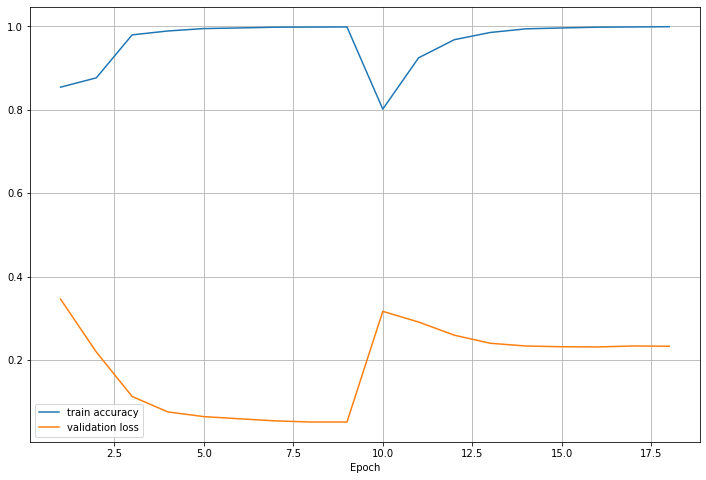

In [34]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.xlabel('Epoch')
plt.grid(), plt.legend()
plt.show()

- Model 2
    - embedding size = 48
    - RNN unit = 24

In [38]:
model2 = Sequential([
    Embedding(vocab_size, 48, input_length=max_len),
    SimpleRNN(24, activation='tanh'),
    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 171, 48)           454992    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 24)                1752      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 456,769
Trainable params: 456,769
Non-trainable params: 0
_________________________________________________________________


In [39]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path2 = 'best_model2.h5'
mc2 = ModelCheckpoint(model_path2, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=10)
hist2 = model2.fit(X_train, y_train,
                   epochs=100, batch_size=64, validation_split=0.2,
                   callbacks=[mc2, es2])

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8698
Epoch 1: val_loss improved from inf to 0.34118, saving model to best_model2.h5
52/52 [==============================] - 4s 58ms/step - loss: 0.4043 - accuracy: 0.8706 - val_loss: 0.3412 - val_accuracy: 0.8827
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9465
Epoch 2: val_loss improved from 0.34118 to 0.10797, saving model to best_model2.h5
52/52 [==============================] - 3s 48ms/step - loss: 0.1932 - accuracy: 0.9465 - val_loss: 0.1080 - val_accuracy: 0.9686
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9868
Epoch 3: val_loss improved from 0.10797 to 0.07060, saving model to best_model2.h5
52/52 [==============================] - 4s 72ms/step - loss: 0.0610 - accuracy: 0.9870 - val_loss: 0.0706 - val_accuracy: 0.9831
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.0317 - ac

In [40]:
best_model2 = load_model(model_path2)
best_model2.evaluate(X_test, y_test)

33/33 [==============================] - 1s 13ms/step - loss: 0.0899 - accuracy: 0.9729


[0.08994169533252716, 0.9729207158088684]

- Model 3
    - embedding size = 24
    - RNN unit = 48

In [41]:
model3 = Sequential([
    Embedding(vocab_size, 24, input_length=max_len),
    SimpleRNN(48, activation='tanh'),
    Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 171, 24)           227496    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 48)                3504      
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 231,049
Trainable params: 231,049
Non-trainable params: 0
_________________________________________________________________


In [42]:
model3.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path3 = 'best_model2.h5'
mc3 = ModelCheckpoint(model_path2, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=10)
hist3 = model3.fit(X_train, y_train,
                   epochs=100, batch_size=64, validation_split=0.2,
                   callbacks=[mc3, es3])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8564
Epoch 1: val_loss improved from inf to 0.32809, saving model to best_model2.h5
52/52 [==============================] - 4s 56ms/step - loss: 0.4013 - accuracy: 0.8564 - val_loss: 0.3281 - val_accuracy: 0.8827
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9537
Epoch 2: val_loss improved from 0.32809 to 0.11392, saving model to best_model2.h5
52/52 [==============================] - 3s 51ms/step - loss: 0.1622 - accuracy: 0.9537 - val_loss: 0.1139 - val_accuracy: 0.9637
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9849
Epoch 3: val_loss improved from 0.11392 to 0.10663, saving model to best_model2.h5
52/52 [==============================] - 3s 49ms/step - loss: 0.0572 - accuracy: 0.9849 - val_loss: 0.1066 - val_accuracy: 0.9661
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.0318 - ac

In [43]:
best_model3 = load_model(model_path3)
best_model3.evaluate(X_test, y_test)

33/33 [==============================] - 1s 10ms/step - loss: 0.0932 - accuracy: 0.9739


[0.0931573286652565, 0.9738878011703491]

- Model 4
    - Embedding size: 48
    - RNN unit: 48

In [44]:
model4 = Sequential([
    Embedding(vocab_size, 48, input_length=max_len),
    SimpleRNN(48, activation='tanh'),
    Dense(1, activation='sigmoid')
])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 171, 48)           454992    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 48)                4656      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 459,697
Trainable params: 459,697
Non-trainable params: 0
_________________________________________________________________


In [45]:
model4.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path4 = 'best_model2.h5'
mc4 = ModelCheckpoint(model_path2, verbose=1, save_best_only=True)
es4 = EarlyStopping(patience=10)
hist4 = model4.fit(X_train, y_train,
                   epochs=100, batch_size=64, validation_split=0.2,
                   callbacks=[mc4, es4])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8600
Epoch 1: val_loss improved from inf to 0.35573, saving model to best_model2.h5
52/52 [==============================] - 5s 71ms/step - loss: 0.4063 - accuracy: 0.8600 - val_loss: 0.3557 - val_accuracy: 0.8827
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.8716
Epoch 2: val_loss improved from 0.35573 to 0.30133, saving model to best_model2.h5
52/52 [==============================] - 4s 74ms/step - loss: 0.3435 - accuracy: 0.8715 - val_loss: 0.3013 - val_accuracy: 0.8827
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9553
Epoch 3: val_loss improved from 0.30133 to 0.07865, saving model to best_model2.h5
52/52 [==============================] - 3s 56ms/step - loss: 0.1297 - accuracy: 0.9559 - val_loss: 0.0787 - val_accuracy: 0.9794
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.0323 - ac

In [46]:
best_model4 = load_model(model_path4)
best_model4.evaluate(X_test, y_test)

33/33 [==============================] - 1s 15ms/step - loss: 0.0719 - accuracy: 0.9778


[0.07187571376562119, 0.9777562618255615]